## Full Surrogate: SVD reconstruct the sim frames from a trained LIN
There are 2 relative errors being computed here. The first is the full surrogate relative error. The second relative error comes from just projecting down into the SVD space and doing reconstructing, i.e. no LIN. I did this because I want to know how much of my error is from LIN vs. SVD. 

## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.mantaflowDatasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage, \
                                    pkl_save, pkl_load, reconFrame, rel_err

#from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

from surrogates4sims.svd import MantaFlowSVDDataset

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import pickle

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "full_svd_manta_MLP"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "0"#,1,2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 
SVDFn = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/svd/svd.pkl'
svd_vec_file = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/svd/mantaSVDvecs.pkl'

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  
patience = 1

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 64
numSamplesToKeep = np.infty #if not debugging
latentDim = 512
simLen = 200

w = 30
numComponents = 16 # this does not include p. so the vectors will be of size numComponents + len(p)
hiddenLayers = [128,128]
hd ='_'.join(map(str,hiddenLayers))
activation = nn.Tanh()

if DEBUG:
    epochs = 2
    numSamplesToKeep = 200
    createDebugData = True
    

versionName = versionName + '_w{}_latentDim{}_hd{}_bz{}_epochs{}'.format(w,numComponents,hd,bz,epochs)
versionName

'full_svd_manta_MLP_GPUs0_w30_latentDim16_hd128_128_bz64_epochs1000'

## Select Personal GPUs

In [ ]:
!nvidia-smi

Wed Oct 14 12:41:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |    571MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |    611MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Wed Oct 14 12:41:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   22C    P2    59W / 250W |   1070MiB / 12196MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   21C    P8    10W / 250W |    611MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Build Latent Vectors (Warning....)
The computation of building the latent vectors takes a loooong time. 
This codes checks to see if svd_vec_file has been saved. If it has, 
it will reload them. 

In [ ]:
if os.path.exists(svd_vec_file):
    data = pkl_load(svd_vec_file)
    train_data = data['train_data']
    test_data = data['test_data']
else:
    svd_data = pkl_load(SVDFn)
    print(svd_data.keys())

    svd_vecs = svd_data['spatialVecs'][:,:numComponents]
    print(svd_vecs.shape)

    trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
    print((len(trainData),len(testData)))

    def createSVDdataset(trainData):

        # datasets may be smaller because: numSamplesToKeep 
        # Be careful the default is for the data to be preprocessed. Therefore, we have to invPrecprocess if 
        # we are looking at relative errors. 
        trainDataset = MantaFlowDataset(trainData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False)
        trainDataLoader = DataLoader(dataset=trainDataset, batch_size=len(trainDataset))
        X_train,p_train = next(iter(trainDataLoader))
        print(X_train.shape, p_train.shape)
        z_train = list(map(lambda x: reconFrame(svd_vecs, x, numComponents),X_train.numpy()))

        train_recons, latent_vec_train = zip(*z_train)
        train_recons = np.array(train_recons)
        latent_vec_train = np.array(latent_vec_train)

        v = np.arange(0,len(latent_vec_train),simLen)

        sims = []
        for idx in v:
            sims.append((latent_vec_train[idx:idx+simLen],p_train[idx:idx+simLen]))
        sims = np.array(sims)
        print('num_sims {}'.format(len(sims)))
        return sims

    train_data = createSVDdataset(trainData)
    test_data = createSVDdataset(testData)
    D = {'train_data':train_data,'test_data':test_data}
    pkl_save(D,svd_vec_file)

In [ ]:
train_data[0][0].shape, train_data[0][1].shape

((200, 512), torch.Size([200, 3]))

In [ ]:
# reduce the dimensions of z down to the numComponents 
for idx,d in enumerate(train_data):
    X = d[0][:,:numComponents]
    p = d[1]
    train_data[idx] = (X,p)
    
for idx,d in enumerate(test_data):
    X = d[0][:,:numComponents]
    p = d[1]
    test_data[idx] = (X,p)
print(X.shape)

(200, 16)


## Investigate how to preprocess the data

In [ ]:
len(train_data), len(test_data)

(95, 10)

In [ ]:
D = []
for d in train_data:
    D.append(np.hstack(d))
D = np.vstack(D)
D.shape

(19000, 19)

In [ ]:
D.max()

32.422386

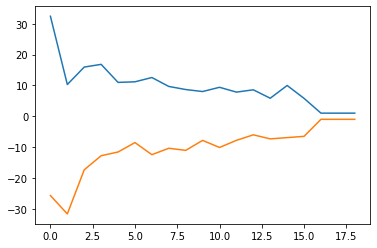

In [ ]:
x_mx = np.max(D,axis=0)
x_mn = np.min(D,axis=0)
plt.plot(x_mx)
plt.plot(x_mn)
plt.show()

## Dataset and Dataloader

In [ ]:
class LatentVectors(Dataset):
    def __init__(self, data,doPreprocess=False,w=1,simLen=200,mx=x_mx,mn=x_mn):
        self.data = data
        self.doPreprocess = doPreprocess
        self.simLen = simLen
        self.w = w
        self.mx = mx
        self.mn = mn
                 
    def __len__(self):
        return self.simLen*len(self.data)

    def preprocess(self,x):
        xnew = 2*((x-self.mn)/(self.mx-self.mn) - .5)
        return xnew

    def invPreprocess(self,xnew):
        x = ((xnew/2)+.5)*(self.mx-self.mn) + self.mn
        return x
    
    def __getitem__(self, idx):
        q,r = np.divmod(idx,self.simLen)
        X,p = self.data[q]
        r_idx = np.random.randint(0,self.simLen-self.w)
        x = np.hstack([X[r_idx:r_idx+1],p[r_idx:r_idx+1]])
        #print(x.shape)
        y = np.hstack([X[r_idx+1:r_idx+self.w+1],p[r_idx+1:r_idx+self.w+1]])
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocess(x)
            y = self.preprocess(y)
        return x, y

In [ ]:
trainDataset = LatentVectors(train_data,doPreprocess=True,w=w,simLen=200,mx=x_mx,mn=x_mn)
testDataset = LatentVectors(test_data,doPreprocess=True,w=w,simLen=200,mx=x_mx,mn=x_mn)

In [ ]:
X,y = trainDataset[4]
X.shape,y.shape

((1, 19), (30, 19))

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)
len(trainDataset), len(trainDataLoader), len(testDataset), len(testDataLoader)

(19000, 296, 2000, 32)

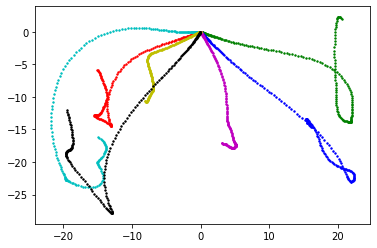

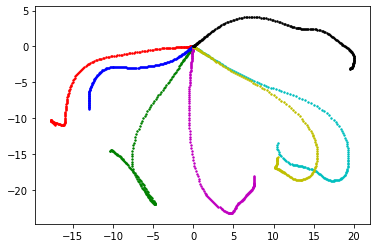

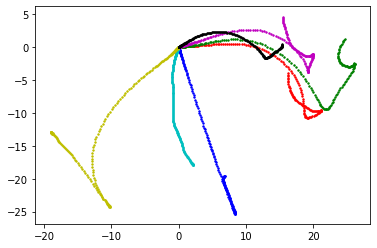

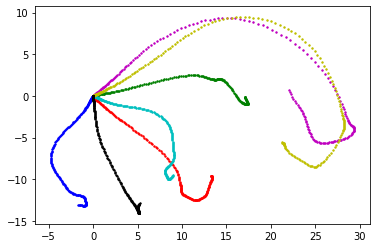

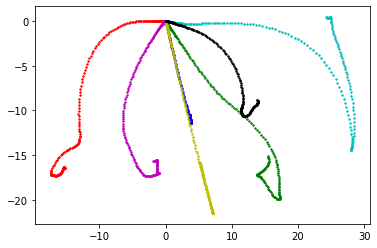

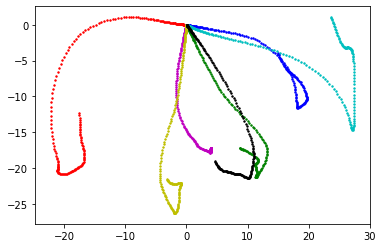

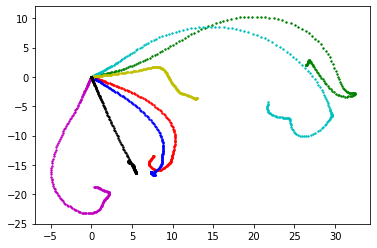

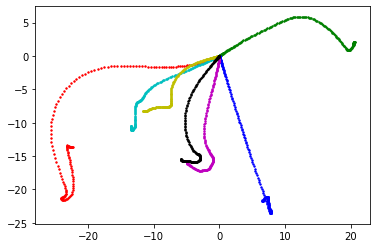

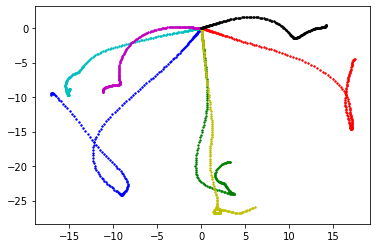

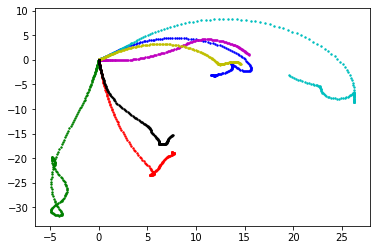

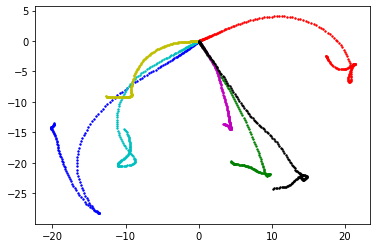

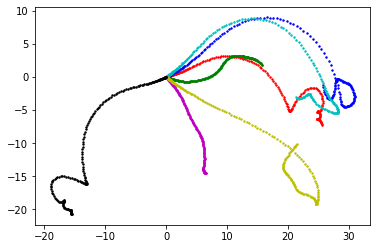

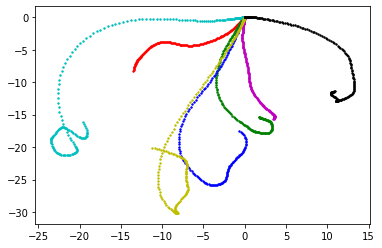

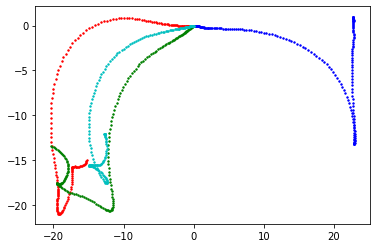

In [ ]:
# plot the first 2 coordinates of the first 3 simulations
# this makes me think that this is going to be a hard problem. 
Dplot = D.reshape(len(train_data),simLen,-1)
colors = ['r','g','b','c','m','y','k']
nc = len(colors)
for sim in range(0,len(train_data),nc):
    A = Dplot[sim:sim+nc]
    for idx, x in enumerate(A):
        plt.scatter(x[:,0],x[:,1],c=colors[idx],s=2)
    plt.show()

## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1]))
            self.modules.append(self.activation)
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.inputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [ ]:
X,y = next(iter(trainDataLoader))
X.shape, y.shape

(torch.Size([64, 1, 19]), torch.Size([64, 30, 19]))

In [ ]:
model = MLP(X, hiddenLayerSizes=hiddenLayers,activation=activation)
model

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=19, bias=True)
  )
)

In [ ]:
output = model(X)
output.shape

torch.Size([64, 1, 19])

In [ ]:
if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
printNumModelParams(model)

6 layers require gradients (unfrozen) out of 6 layers
21,523 parameters require gradients (unfrozen) out of 21,523 parameters


## Loss Function

In [ ]:
L = nn.MSELoss()

In [ ]:
L(output,y[:,0:1,:])

tensor(0.1482, grad_fn=<MseLossBackward>)

In [ ]:
sum_loss = 0
out = X.clone()
for idx in range(w):
    out = model(out).clone()
    sum_loss += L(out,y[:,idx:idx+1,:])
sum_loss

tensor(4.6105, grad_fn=<AddBackward0>)

In [ ]:
combined_loss = L(output,y)
combined_loss.backward()

/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64, 30, 19])) that is different to the input size (torch.Size([64, 1, 19])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Set LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



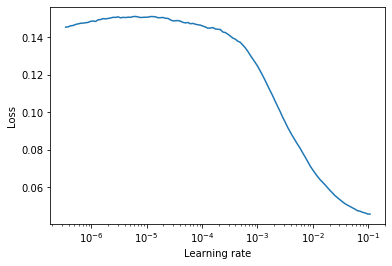

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)


In [ ]:
max_lr = .001
opt = torch.optim.Adam(model.parameters(), lr=max_lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

In [ ]:
versionName

'full_svd_manta_MLP_GPUs0_w30_latentDim16_hd128_128_bz64_epochs1000_lr0.001'

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        combined_loss = 0.
        
        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        y_hat = X.clone()
        predictions = []
        for w_idx in range(w):
            y_hat = model(y_hat).clone()
            y_hat[:,:,-p.shape[1]:] = y[:,w_idx:w_idx+1,-p.shape[1]:]
            predictions.append(y_hat)
            combined_loss += loss(y_hat,y[:,w_idx:w_idx+1,:])
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss

        # --- Metrics Recording ---

        # metrics
        predictions = torch.stack(predictions)
        r = metric(y_hat, y)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps


In [ ]:
def validEpoch(myDataLoader, tensorboard_writer, model, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        combined_loss = 0.
        # --- Metrics Recording ---

        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # forward, no gradient calculations
        with torch.no_grad():
            y_hat = X.clone()
            predictions = []
            for w_idx in range(w):
                y_hat = model(y_hat).clone()
                y_hat[:,:,-p.shape[1]:] = y[:,w_idx:w_idx+1,-p.shape[1]:]
                predictions.append(y_hat)
                combined_loss += loss(y_hat,y[:,w_idx:w_idx+1,:])

        running_loss += combined_loss.item()

        # metrics
        predictions = torch.stack(predictions)
        r = metric(y_hat, y)
        running_rmse += r

    avg_running_loss = running_loss/len(myDataLoader)
    avg_running_rmse = running_rmse/len(myDataLoader)
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return avg_running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
model = model.to(device)
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, L,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#     if trainLoss < bestLoss:
#         bestLoss = trainLoss
#         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, L, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

    #checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(trainLoss)
    #lr_scheduler.step(valLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 1.7347e+00
LR: 1.0000e-03


  0%|          | 1/1000 [00:21<5:53:38, 21.24s/it]

valLoss: 1.6732e+00
Better valLoss: 1.6732e+00, Saving models...
--- Epoch 2/1000 ---
trainLoss: 1.4320e+00
LR: 1.0000e-03


  0%|          | 2/1000 [00:43<5:56:36, 21.44s/it]

valLoss: 1.3849e+00
Better valLoss: 1.3849e+00, Saving models...
--- Epoch 3/1000 ---
trainLoss: 1.1580e+00
LR: 1.0000e-03


  0%|          | 3/1000 [00:59<5:28:39, 19.78s/it]

valLoss: 1.1718e+00
Better valLoss: 1.1718e+00, Saving models...
--- Epoch 4/1000 ---
trainLoss: 9.8210e-01
LR: 1.0000e-03


  0%|          | 4/1000 [01:20<5:37:01, 20.30s/it]

valLoss: 1.0429e+00
Better valLoss: 1.0429e+00, Saving models...
--- Epoch 5/1000 ---
trainLoss: 8.4343e-01
LR: 1.0000e-03


  0%|          | 5/1000 [01:42<5:44:11, 20.76s/it]

valLoss: 9.1998e-01
Better valLoss: 9.1998e-01, Saving models...
--- Epoch 6/1000 ---
trainLoss: 7.6834e-01
LR: 1.0000e-03


  1%|          | 6/1000 [02:01<5:33:12, 20.11s/it]

valLoss: 8.2756e-01
Better valLoss: 8.2756e-01, Saving models...
--- Epoch 7/1000 ---
trainLoss: 7.0418e-01
LR: 1.0000e-03


  1%|          | 7/1000 [02:20<5:29:41, 19.92s/it]

valLoss: 7.7130e-01
Better valLoss: 7.7130e-01, Saving models...
--- Epoch 8/1000 ---
trainLoss: 6.5601e-01
LR: 1.0000e-03


  1%|          | 8/1000 [02:42<5:37:52, 20.44s/it]

valLoss: 7.1803e-01
Better valLoss: 7.1803e-01, Saving models...
--- Epoch 9/1000 ---
trainLoss: 5.9931e-01
LR: 1.0000e-03


  1%|          | 9/1000 [03:02<5:36:29, 20.37s/it]

valLoss: 8.2346e-01
--- Epoch 10/1000 ---
trainLoss: 5.6304e-01
LR: 1.0000e-03


  1%|          | 10/1000 [03:20<5:25:35, 19.73s/it]

valLoss: 6.5462e-01
Better valLoss: 6.5462e-01, Saving models...
--- Epoch 11/1000 ---
trainLoss: 5.2544e-01
LR: 1.0000e-03


  1%|          | 11/1000 [03:31<4:40:17, 17.00s/it]

valLoss: 6.3965e-01
Better valLoss: 6.3965e-01, Saving models...
--- Epoch 12/1000 ---
trainLoss: 4.9615e-01
LR: 1.0000e-03


  1%|          | 12/1000 [03:47<4:35:57, 16.76s/it]

valLoss: 6.5316e-01
--- Epoch 13/1000 ---
trainLoss: 4.6242e-01
LR: 1.0000e-03


  1%|▏         | 13/1000 [04:10<5:08:27, 18.75s/it]

valLoss: 6.7343e-01
--- Epoch 14/1000 ---
trainLoss: 4.5214e-01
LR: 1.0000e-03


  1%|▏         | 14/1000 [04:30<5:10:37, 18.90s/it]

valLoss: 6.2683e-01
Better valLoss: 6.2683e-01, Saving models...
--- Epoch 15/1000 ---
trainLoss: 4.3492e-01
LR: 1.0000e-03


  2%|▏         | 15/1000 [04:48<5:05:47, 18.63s/it]

valLoss: 5.8127e-01
Better valLoss: 5.8127e-01, Saving models...
--- Epoch 16/1000 ---
trainLoss: 4.1764e-01
LR: 1.0000e-03


  2%|▏         | 16/1000 [05:11<5:27:19, 19.96s/it]

valLoss: 5.7521e-01
Better valLoss: 5.7521e-01, Saving models...
--- Epoch 17/1000 ---
trainLoss: 4.0634e-01
LR: 1.0000e-03


  2%|▏         | 17/1000 [05:21<4:40:48, 17.14s/it]

valLoss: 5.6299e-01
Better valLoss: 5.6299e-01, Saving models...
--- Epoch 18/1000 ---
trainLoss: 3.9987e-01
LR: 1.0000e-03


  2%|▏         | 18/1000 [05:33<4:13:41, 15.50s/it]

valLoss: 5.4154e-01
Better valLoss: 5.4154e-01, Saving models...
--- Epoch 19/1000 ---
trainLoss: 3.7865e-01
LR: 1.0000e-03


  2%|▏         | 19/1000 [05:49<4:17:55, 15.78s/it]

valLoss: 4.9100e-01
Better valLoss: 4.9100e-01, Saving models...
--- Epoch 20/1000 ---
trainLoss: 3.7205e-01
LR: 1.0000e-03


  2%|▏         | 20/1000 [06:06<4:23:13, 16.12s/it]

valLoss: 6.3606e-01
--- Epoch 21/1000 ---
trainLoss: 3.6815e-01
LR: 1.0000e-03


  2%|▏         | 21/1000 [06:18<4:00:36, 14.75s/it]

valLoss: 5.5680e-01
--- Epoch 22/1000 ---
trainLoss: 3.5793e-01
LR: 1.0000e-03


  2%|▏         | 22/1000 [06:34<4:07:34, 15.19s/it]

valLoss: 5.4719e-01
--- Epoch 23/1000 ---
trainLoss: 3.4902e-01
LR: 1.0000e-03


  2%|▏         | 23/1000 [06:53<4:25:11, 16.29s/it]

valLoss: 4.8849e-01
Better valLoss: 4.8849e-01, Saving models...
--- Epoch 24/1000 ---
trainLoss: 3.4860e-01
LR: 1.0000e-03


  2%|▏         | 24/1000 [07:13<4:46:26, 17.61s/it]

valLoss: 5.6733e-01
--- Epoch 25/1000 ---
trainLoss: 3.3807e-01
LR: 1.0000e-03


  2%|▎         | 25/1000 [07:35<5:03:43, 18.69s/it]

valLoss: 5.3603e-01
--- Epoch 26/1000 ---
trainLoss: 3.3135e-01
LR: 1.0000e-03


  3%|▎         | 26/1000 [07:50<4:47:14, 17.69s/it]

valLoss: 5.1978e-01
--- Epoch 27/1000 ---
trainLoss: 3.2483e-01
LR: 1.0000e-03


  3%|▎         | 27/1000 [08:01<4:11:59, 15.54s/it]

valLoss: 5.5288e-01
--- Epoch 28/1000 ---
trainLoss: 3.1922e-01
LR: 1.0000e-03


  3%|▎         | 28/1000 [08:19<4:25:14, 16.37s/it]

valLoss: 5.4291e-01
--- Epoch 29/1000 ---
trainLoss: 3.2660e-01
LR: 1.0000e-03


  3%|▎         | 29/1000 [08:35<4:25:37, 16.41s/it]

valLoss: 5.6443e-01
--- Epoch 30/1000 ---
trainLoss: 3.1824e-01
LR: 1.0000e-03


  3%|▎         | 30/1000 [08:48<4:07:55, 15.34s/it]

valLoss: 5.5063e-01
--- Epoch 31/1000 ---
trainLoss: 3.3329e-01
LR: 1.0000e-03


  3%|▎         | 31/1000 [09:02<4:00:36, 14.90s/it]

valLoss: 5.6421e-01
--- Epoch 32/1000 ---
trainLoss: 3.0874e-01
LR: 1.0000e-03


  3%|▎         | 32/1000 [09:16<3:56:08, 14.64s/it]

valLoss: 4.8995e-01
--- Epoch 33/1000 ---
trainLoss: 3.0375e-01
LR: 1.0000e-03


  3%|▎         | 33/1000 [09:33<4:07:08, 15.33s/it]

valLoss: 5.7774e-01
--- Epoch 34/1000 ---
trainLoss: 3.0621e-01
LR: 1.0000e-03


  3%|▎         | 34/1000 [09:47<3:57:34, 14.76s/it]

valLoss: 5.5021e-01
--- Epoch 35/1000 ---
trainLoss: 3.0471e-01
LR: 1.0000e-03


  4%|▎         | 35/1000 [09:57<3:37:20, 13.51s/it]

valLoss: 5.4982e-01
--- Epoch 36/1000 ---
trainLoss: 2.0670e-01
LR: 1.0000e-04


  4%|▎         | 36/1000 [10:16<4:04:08, 15.20s/it]

valLoss: 4.5690e-01
Better valLoss: 4.5690e-01, Saving models...
--- Epoch 37/1000 ---
trainLoss: 1.9996e-01
LR: 1.0000e-04


  4%|▎         | 37/1000 [10:42<4:55:24, 18.41s/it]

valLoss: 4.5464e-01
Better valLoss: 4.5464e-01, Saving models...
--- Epoch 38/1000 ---
trainLoss: 1.9943e-01
LR: 1.0000e-04


  4%|▍         | 38/1000 [11:07<5:25:02, 20.27s/it]

valLoss: 4.4734e-01
Better valLoss: 4.4734e-01, Saving models...
--- Epoch 39/1000 ---
trainLoss: 1.9654e-01
LR: 1.0000e-04


  4%|▍         | 39/1000 [11:20<4:52:06, 18.24s/it]

valLoss: 4.5946e-01
--- Epoch 40/1000 ---
trainLoss: 1.9730e-01
LR: 1.0000e-04


  4%|▍         | 40/1000 [11:45<5:22:49, 20.18s/it]

valLoss: 4.4537e-01
Better valLoss: 4.4537e-01, Saving models...
--- Epoch 41/1000 ---
trainLoss: 1.9207e-01
LR: 1.0000e-04


  4%|▍         | 41/1000 [12:08<5:35:27, 20.99s/it]

valLoss: 4.4451e-01
Better valLoss: 4.4451e-01, Saving models...
--- Epoch 42/1000 ---
trainLoss: 1.9282e-01
LR: 1.0000e-04


  4%|▍         | 42/1000 [12:27<5:26:34, 20.45s/it]

valLoss: 4.3245e-01
Better valLoss: 4.3245e-01, Saving models...
--- Epoch 43/1000 ---
trainLoss: 1.9328e-01
LR: 1.0000e-04


  4%|▍         | 43/1000 [12:42<5:01:24, 18.90s/it]

valLoss: 4.7421e-01
--- Epoch 44/1000 ---
trainLoss: 1.8328e-01
LR: 1.0000e-05


  4%|▍         | 44/1000 [13:05<5:16:53, 19.89s/it]

valLoss: 4.3739e-01
--- Epoch 45/1000 ---
trainLoss: 1.7948e-01
LR: 1.0000e-05


  4%|▍         | 45/1000 [13:25<5:19:27, 20.07s/it]

valLoss: 4.4924e-01
--- Epoch 46/1000 ---
trainLoss: 1.8321e-01
LR: 1.0000e-05


  5%|▍         | 46/1000 [13:45<5:19:02, 20.07s/it]

valLoss: 4.4768e-01
--- Epoch 47/1000 ---
trainLoss: 1.8136e-01
LR: 1.0000e-05


  5%|▍         | 47/1000 [13:59<4:47:51, 18.12s/it]

valLoss: 4.3791e-01
--- Epoch 48/1000 ---
trainLoss: 1.8114e-01
LR: 1.0000e-06


  5%|▍         | 48/1000 [14:15<4:37:29, 17.49s/it]

valLoss: 4.2538e-01
Better valLoss: 4.2538e-01, Saving models...
--- Epoch 49/1000 ---
trainLoss: 1.8057e-01
LR: 1.0000e-06


  5%|▍         | 49/1000 [14:25<4:05:04, 15.46s/it]

valLoss: 4.3931e-01
--- Epoch 50/1000 ---
trainLoss: 1.8092e-01
LR: 1.0000e-07


  5%|▌         | 50/1000 [14:47<4:33:32, 17.28s/it]

valLoss: 4.5000e-01
--- Epoch 51/1000 ---
trainLoss: 1.8158e-01
LR: 1.0000e-07
valLoss: 4.2242e-01
Better valLoss: 4.2242e-01, Saving models...
---------- Finished Training ----------


## LIN Errors: Test on the best validation model on Full simLen

In [ ]:
def invPreprocess(xnew):
    x = ((xnew/2)+.5)*(x_mx-x_mn) + x_mn
    return x


def test_model(model,test_ind,doPlot=False):
    # last model
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],doPreprocess=True,w=simLen-1,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))
    X.shape, y.shape

    xhat = X.to(device).clone()
    out = []
    for idx in range(y.shape[1]):
        xhat = model(xhat).clone()
        xhat[:,:,-p.shape[1]:] = y[:,idx:idx+1,-p.shape[1]:]
        out.append(xhat)
    out = torch.stack(out).squeeze()

    yy = y.squeeze().to(device)
    err = []
    for i in range(out.shape[0]):
        e = invPreprocess(yy[i].detach().cpu().numpy()) - invPreprocess(out[i].detach().cpu().numpy())
        err.append(np.linalg.norm(e))

    if doPlot:
        plt.plot(err)
        plt.title('Test Sample'.format(test_ind))
        
    return err

In [ ]:
# best val loss model
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)
model.eval()

MLP(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=19, bias=True)
  )
)

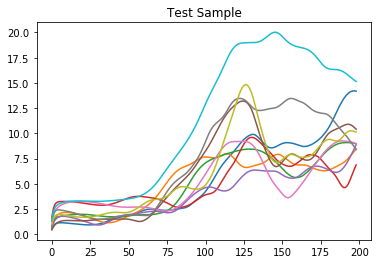

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model(model,idx,True)
    Err.append(e)

In [ ]:
np.mean(Err)

6.098501

In [ ]:
def test_model_rel_err(model,test_ind,doPlot=False):
    # last model
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],doPreprocess=True,w=simLen-1,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))
    X.shape, y.shape

    xhat = X.to(device).clone()
    out = []
    for idx in range(y.shape[1]):
        xhat = model(xhat).clone()
        xhat[:,:,-p.shape[1]:] = y[:,idx:idx+1,-p.shape[1]:]
        out.append(xhat)
    out = torch.stack(out).squeeze()

    yy = y.squeeze().to(device)
    err = []
    for i in range(out.shape[0]):
        label = invPreprocess(yy[i].detach().cpu().numpy())
        e =  label - invPreprocess(out[i].detach().cpu().numpy())
        err.append(np.linalg.norm(e)/np.linalg.norm(label))

    if doPlot:
        plt.plot(err)
        plt.title('Test Samples Relative Errors'.format(test_ind))
        
    return err

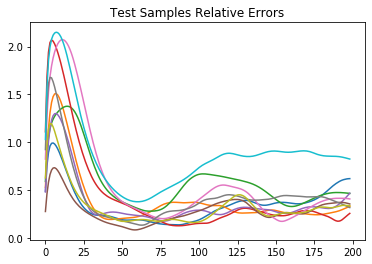

In [ ]:
Err = []
for idx in range(len(test_data)):  
    e = test_model_rel_err(model,idx,True)
    Err.append(e)

## Full Surrogate: Reconstruct the Sim frames
There are 2 relative errors being computed here. The first is the full surrogate relative error. The second relative error comes from just projecting down into the SVD space and doing reconstructing, i.e. no LIN. I did this because I want to know how much of my error is from LIN vs. SVD.  

In [ ]:
trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
print((len(trainData),len(testData)))

(19000, 2000)


In [ ]:
testDataset = MantaFlowDataset(testData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False)
testDataLoader = DataLoader(dataset=testDataset, batch_size=len(testDataset))
X_test,p_test = next(iter(testDataLoader))
print(X_test.shape, p_test.shape)


100%|██████████| 2000/2000 [00:03<00:00, 521.51it/s]


torch.Size([2000, 2, 128, 96]) torch.Size([2000, 3])


In [ ]:
c,h,width = X_test.shape[1:]
test_sims = []
for i in range(len(test_data)):
    A = X_test[simLen*i:simLen*(i+1),:]
    test_sims.append(A)
test_sims = torch.stack(test_sims)
test_sims.shape

torch.Size([10, 200, 2, 128, 96])

In [ ]:
# Ground truth SVD latent vectors (no LIN) 
test_data.shape

(10, 2)

In [ ]:
test_data[0][0].shape

(200, 16)

In [ ]:
svd_data = pkl_load(SVDFn)
print(svd_data.keys())

svd_vecs = svd_data['spatialVecs'][:,:numComponents]
print(svd_vecs.shape)

dict_keys(['spatialVecs', 'S', 'timeVecs_transpose'])
(24576, 16)


In [ ]:
def reconFrameOnly(svd_vecs,coeffs):
    R = np.zeros(svd_vecs.shape[0],)
    for idx, c in enumerate(coeffs):
        R += c*svd_vecs[:,idx]
    R = R.reshape(2,128,96)
    return R

In [ ]:
def predictLatentVectors(model,test_ind):
    # last model
    idx = test_ind # choose one of the test samples
    testDataset = LatentVectors(test_data[idx:idx+1],doPreprocess=True,w=simLen-1,mx=x_mx,mn=x_mn)
    testDataLoader = DataLoader(dataset=testDataset, batch_size=1)
    X,y = next(iter(testDataLoader))

    xhat = X.to(device).clone()
    out = []
    for idx in range(y.shape[1]):
        xhat = model(xhat).clone()
        xhat[:,:,-p.shape[1]:] = y[:,idx:idx+1,-p.shape[1]:]
        out.append(xhat)
    out = torch.stack(out).squeeze()
    return out

In [ ]:
## turn the above into a function:
def get_lin_and_svd_rel_err(test_ind):
    z = predictLatentVectors(model,test_ind)
    invPreProcZ = []
    for zz in z:
        invPreProcZ.append(invPreprocess(zz.detach().cpu().numpy()))
    invPreProcZ = np.array(invPreProcZ)
    
    # reconstruct the sim from the LIN latent vectors
    Xhat_LIN = []
    for zz in invPreProcZ:
        coeffs = zz[:numComponents]
        R = reconFrameOnly(svd_vecs,coeffs)
        Xhat_LIN.append(R)
    Xhat_LIN = np.array(Xhat_LIN)
    
    # reconstruct the sim from the ground truth latent vectors
    Xhat = []
    for zz in test_data[test_ind][0][1:]:
        coeffs = zz[:numComponents]
        R = reconFrameOnly(svd_vecs,coeffs)
        Xhat.append(R)
    Xhat = np.array(Xhat)
    
    ground_truth = np.array(test_sims[test_ind,1:,:,:,:])
    
    return Xhat_LIN, Xhat, ground_truth


In [ ]:
svd_rel_err = []
lin_rel_err = []
for test_ind in range(len(test_data)):
    Xhat_LIN, Xhat, ground_truth = get_lin_and_svd_rel_err(test_ind)
    rel_err_svd_only = rel_err(ground_truth,Xhat)
    rel_err_lin = rel_err(ground_truth,Xhat_LIN)
    print('Test Ind {} SVD: {} LIN: {}'.format(test_ind,rel_err_svd_only, rel_err_lin))
    svd_rel_err.append(rel_err_svd_only)
    lin_rel_err.append(rel_err_lin)
    ## To Do: Investigate the rel_err vs. frame index. (it should be getting worse as the index increases)
    # use Xhat_LIN, Xhat, ground_truth to do this. 

Test Ind 0 SVD: 0.40223212989257556 LIN: 0.5198937759424235
Test Ind 1 SVD: 0.33720420944958085 LIN: 0.4347201680105392
Test Ind 2 SVD: 0.41022319066813795 LIN: 0.6033227218043989
Test Ind 3 SVD: 0.34131175995670243 LIN: 0.4120153281951296
Test Ind 4 SVD: 0.41550690194566886 LIN: 0.49516357975917746
Test Ind 5 SVD: 0.34249901801169774 LIN: 0.44345908234406767
Test Ind 6 SVD: 0.4193339258933842 LIN: 0.5411129718503758
Test Ind 7 SVD: 0.365168054493422 LIN: 0.5175633764464084
Test Ind 8 SVD: 0.342402290225114 LIN: 0.4379838689613753
Test Ind 9 SVD: 0.49057082995695855 LIN: 0.8676922533056537


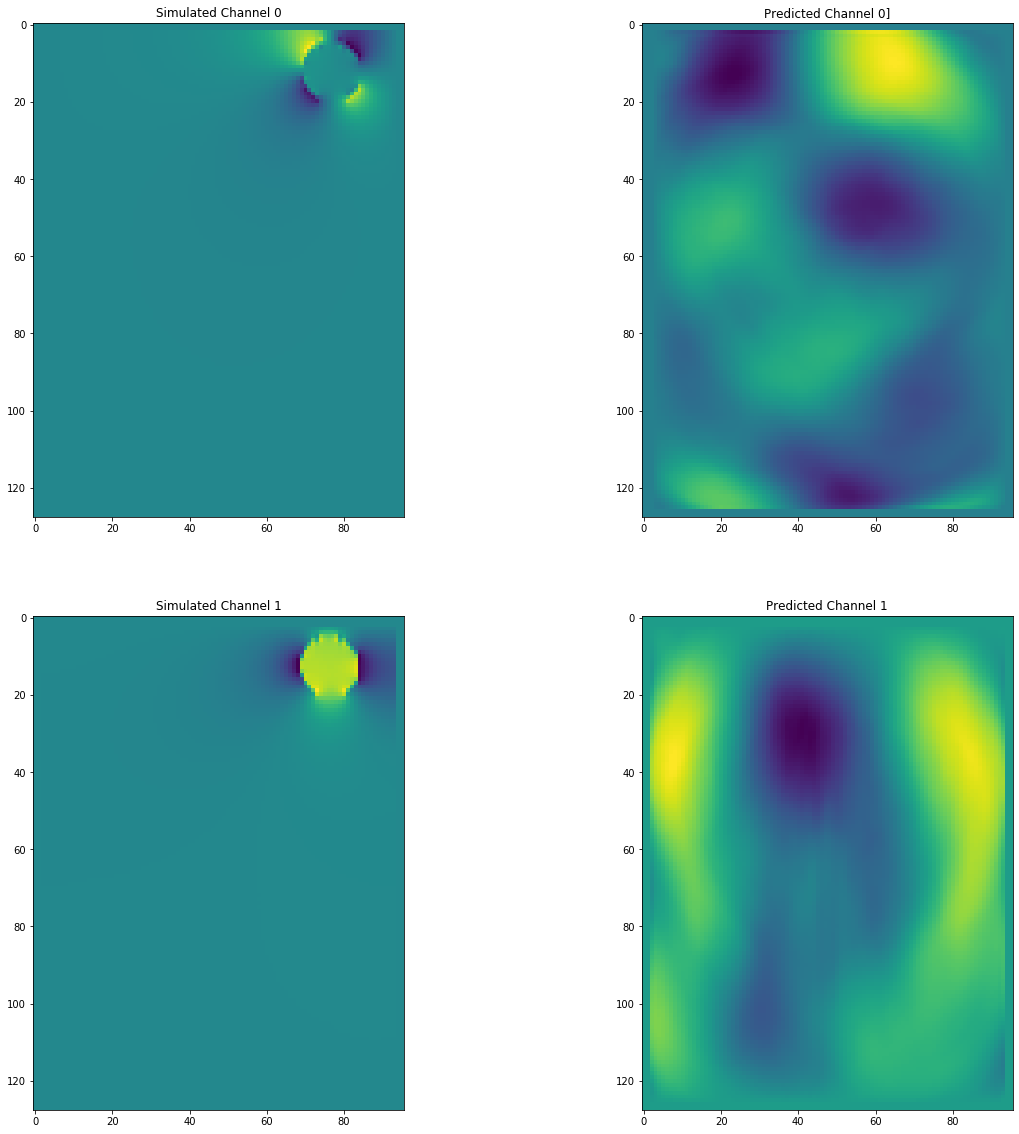

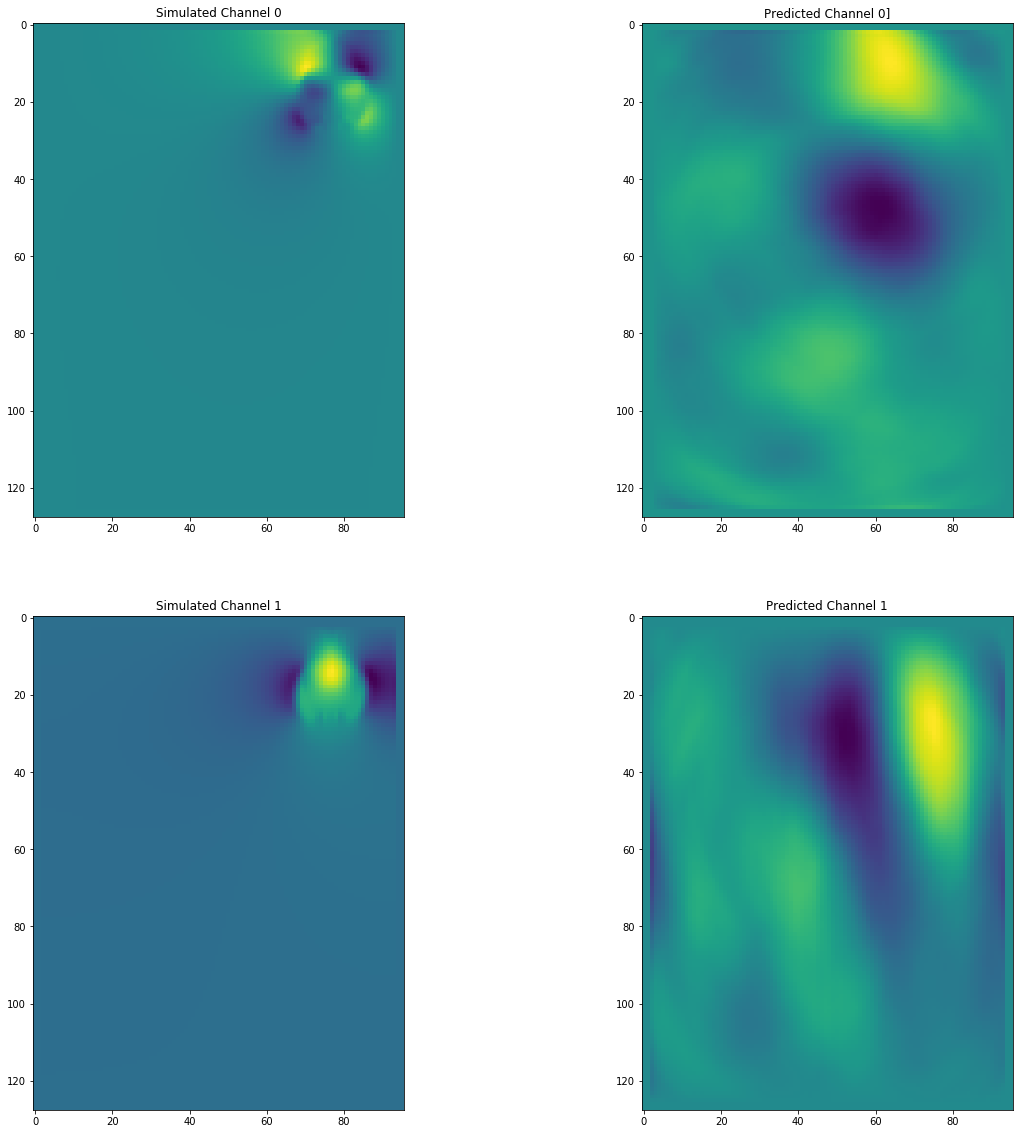

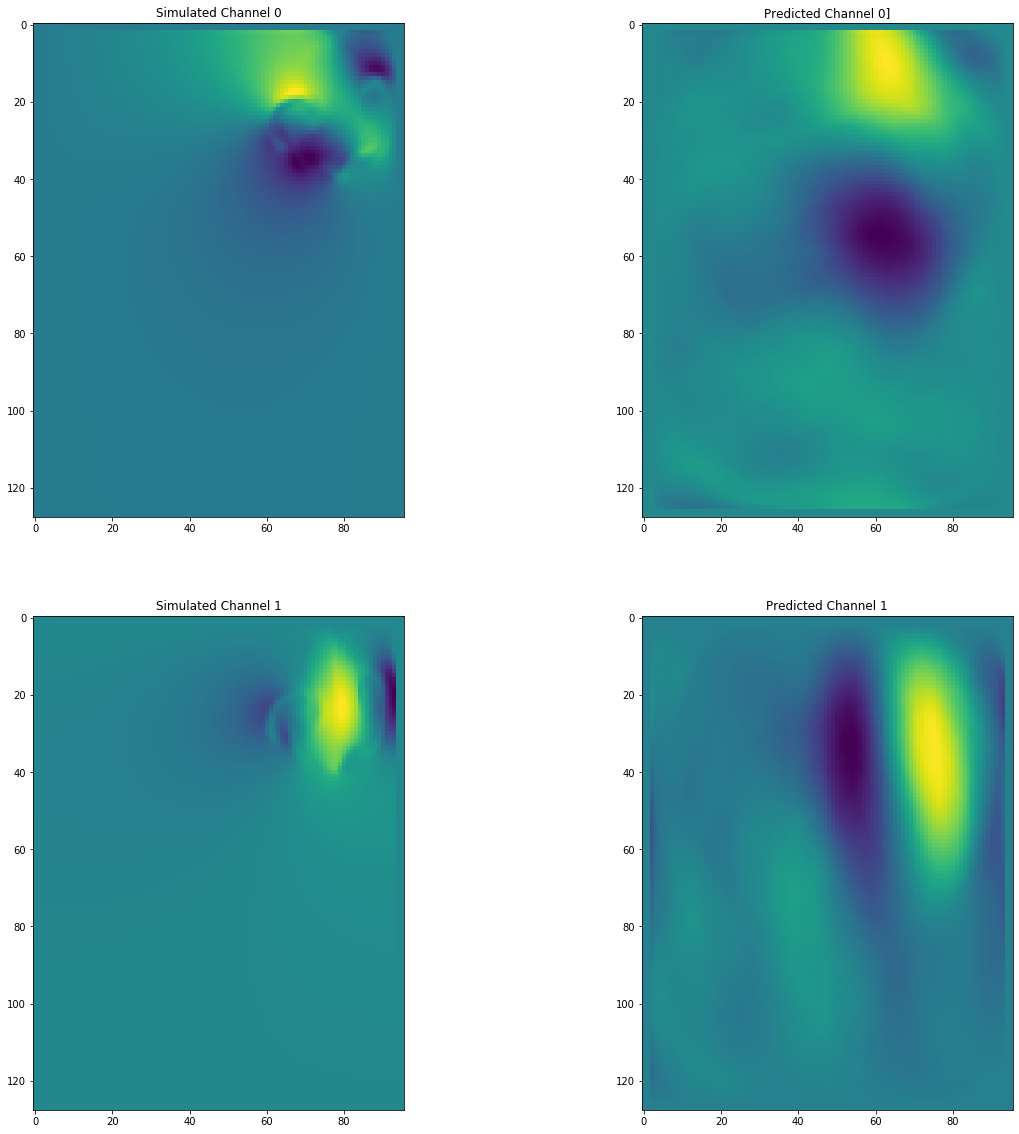

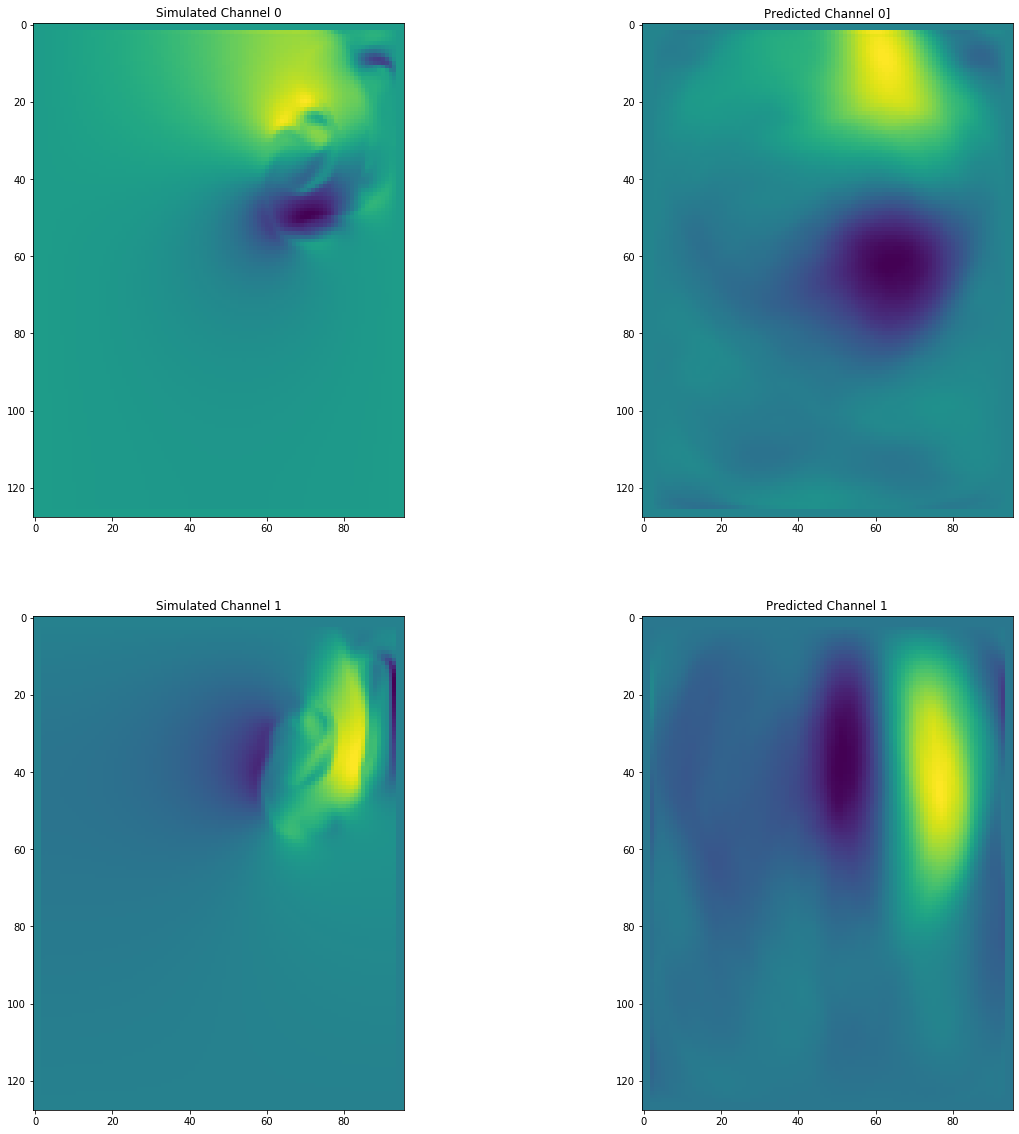

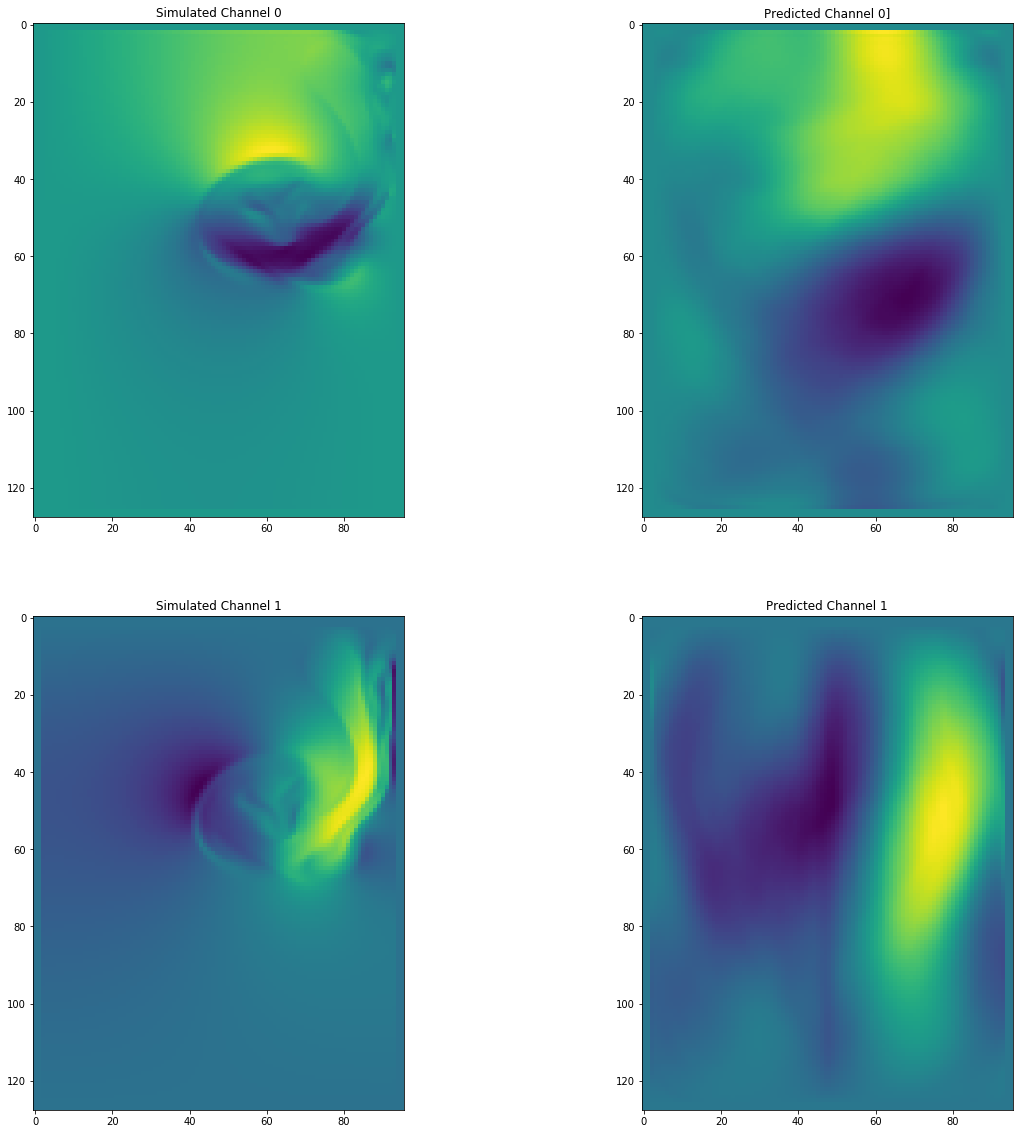

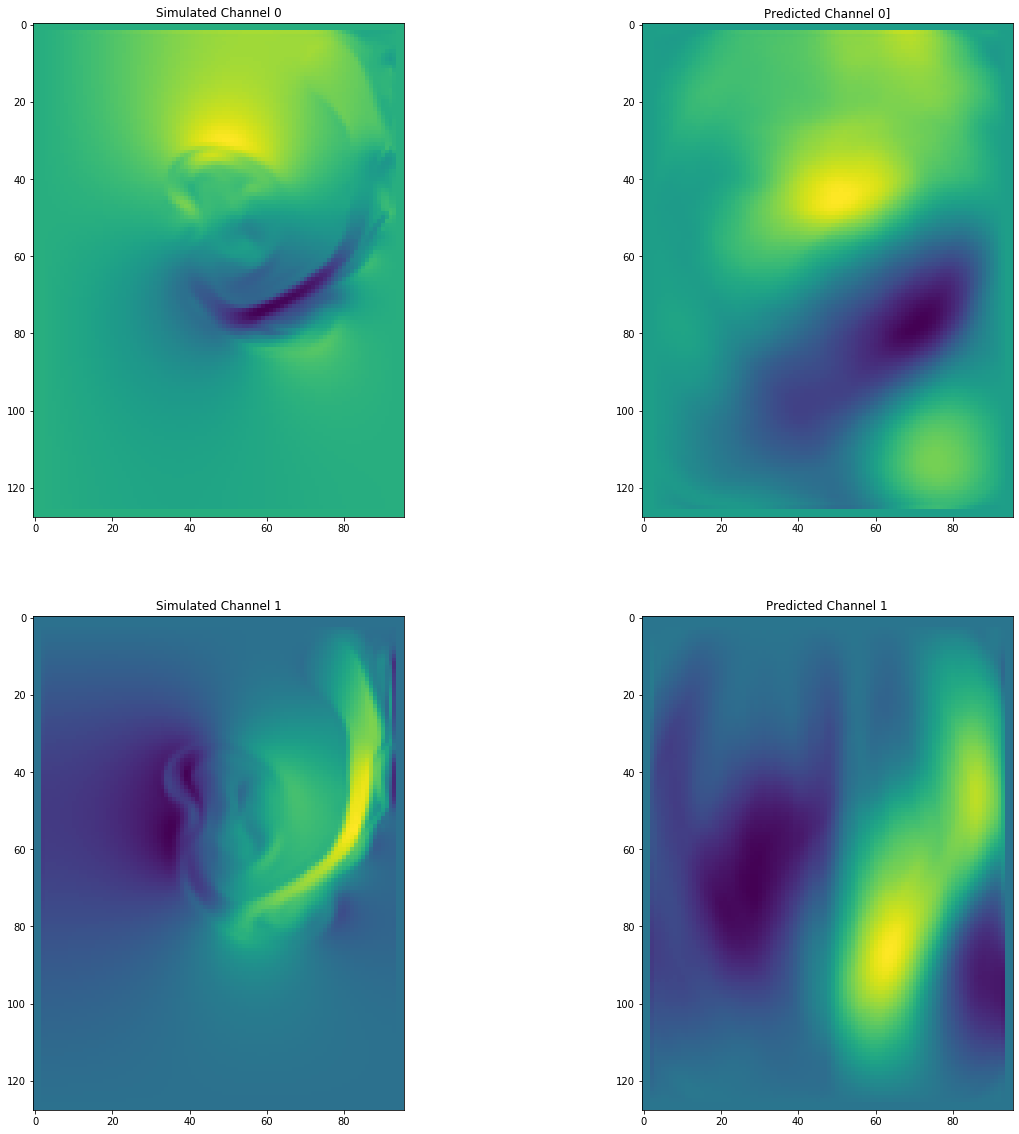

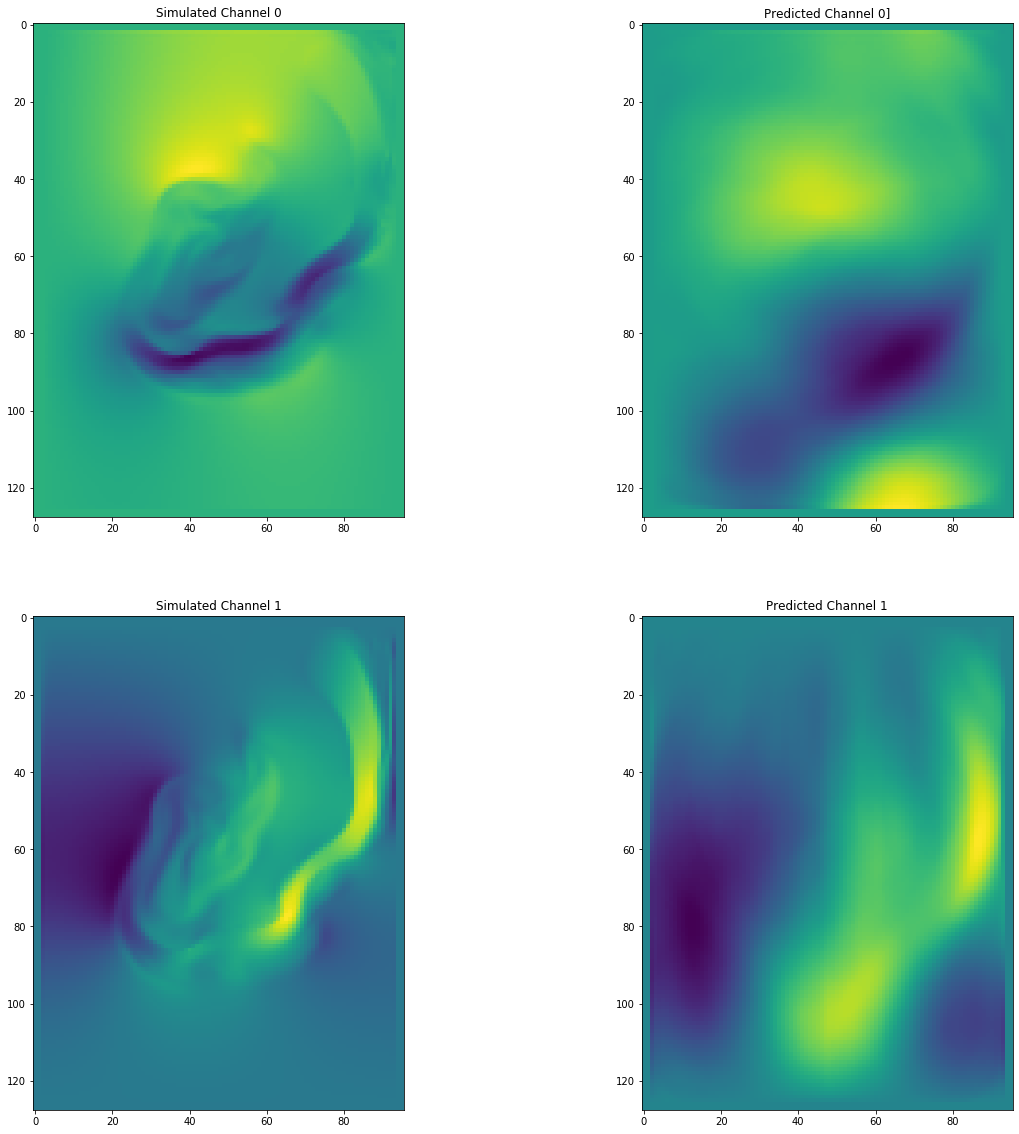

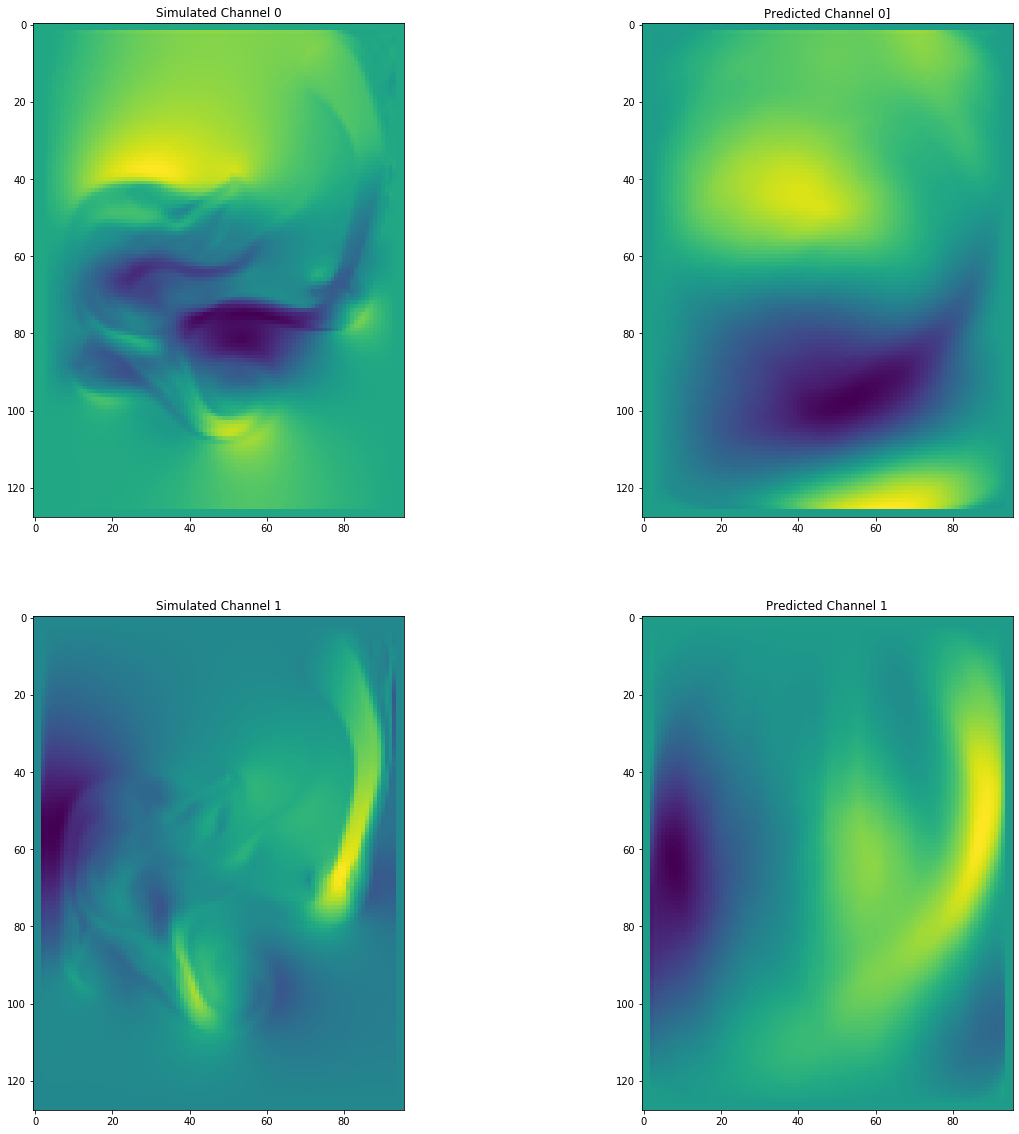

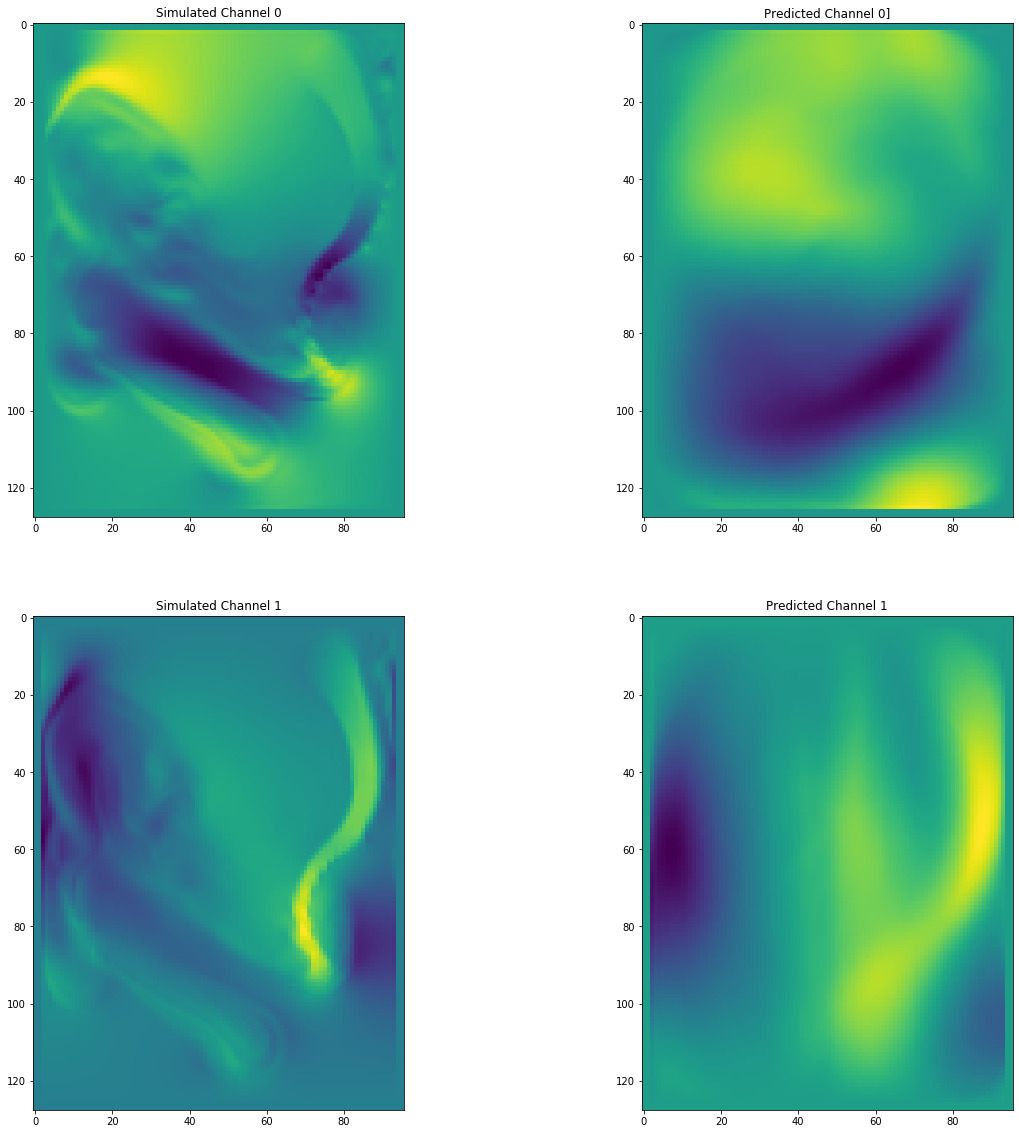

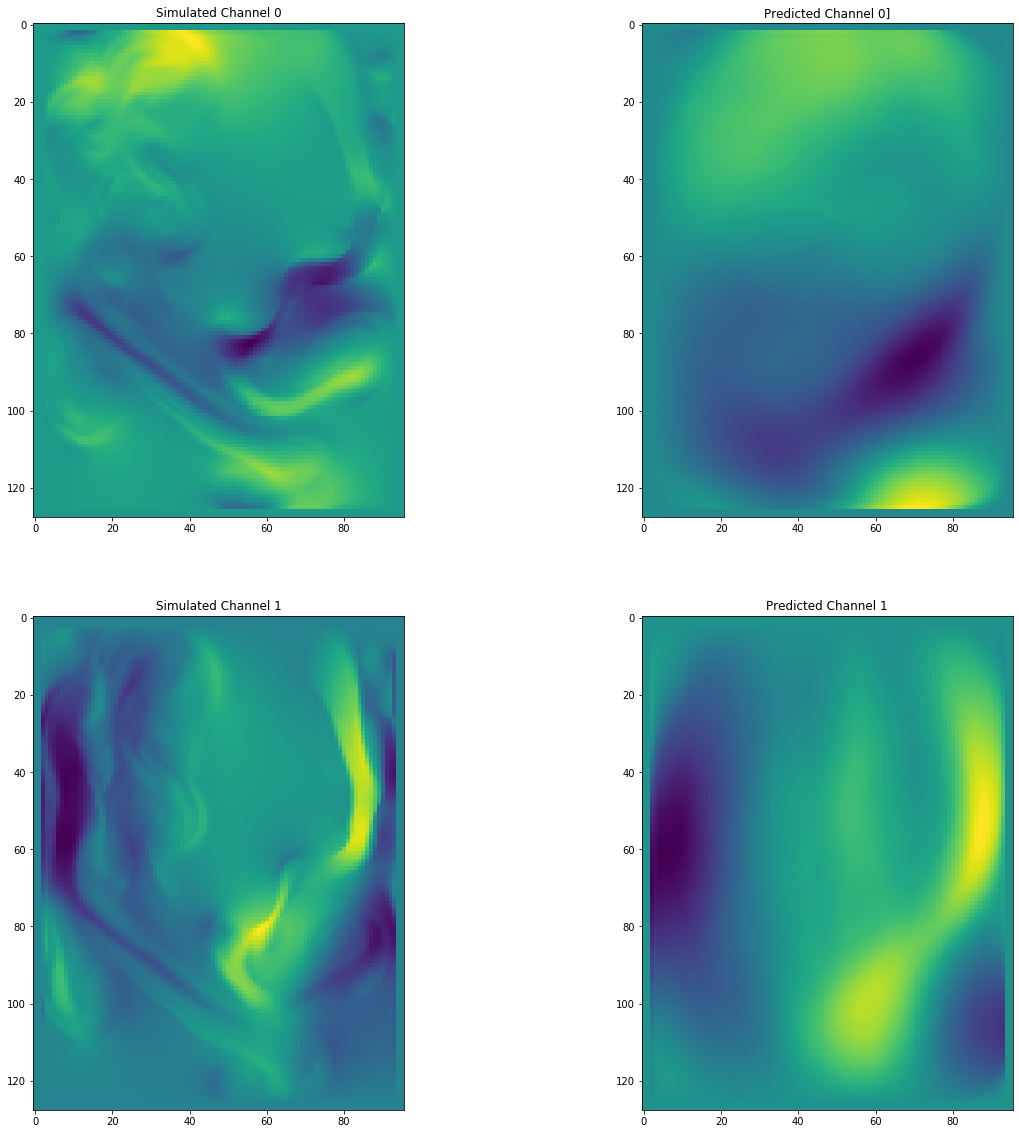

In [ ]:
# sanity check
inds = np.arange(0,200,20)
for frame,pred in zip(ground_truth[inds],Xhat_LIN[inds]):
    plotSampleWpredictionByChannel(frame,pred)